In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
%matplotlib notebook
from scipy.interpolate import CubicSpline


### Run methods

In [66]:
#tune parameters here:
step_size=0.25
beta=0.99
iterations=450

global L,gamma,tau
L=3/2
gamma=1
tau=1/2



<IPython.core.display.Javascript object>


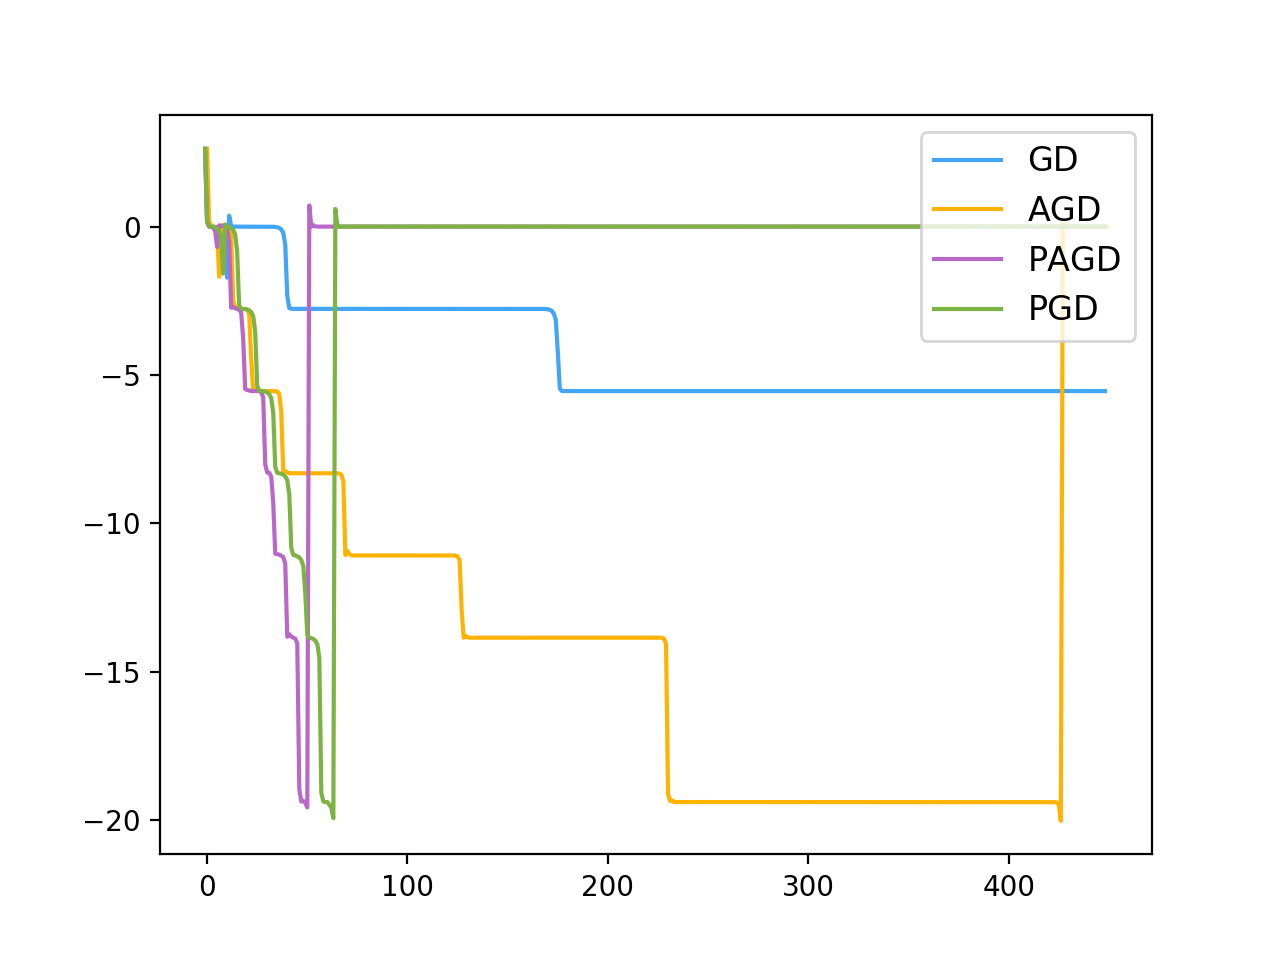

In [75]:
no_of_runs=1
accuracy=1e-10
global loss_type
loss_type='tube'

list_loss = []
list_x = []
list_methods = []
list_steps = []
#plot limits
limits=np.array((0,3))

GD=True
PGD=True
AGD=True
PAGD=True
Momentum=False

y_0=0.5
x_0=0.01

w_0=np.array((x_0,y_0,y_0,y_0,y_0,y_0,y_0,y_0))

if GD:
    loss_collector=[]
    x_collector=[]
    for k in range(no_of_runs):
        (GD_steps,_x,_loss)= Gradient_Descent(w_0,iterations,step_size,accuracy)
        loss_collector.append(_loss)
        x_collector.append(_x)
    GD_loss = [float(sum(col))/len(col) for col in zip(*loss_collector)]
    GD_x =[float(sum(col))/len(col) for col in zip(*x_collector)]   
    
    list_loss.append(GD_loss)
    list_x.append(GD_x)
    list_methods.append('GD')
    list_steps.append(GD_steps)
 
if AGD:
    loss_collector=[]
    x_collector=[]
    for k in range(no_of_runs):
        (AGD_steps,_x,_loss)= Accelerated_Gradient_Descent(w_0,iterations,step_size,accuracy,beta)
        loss_collector.append(_loss)
        x_collector.append(_x)
    AGD_loss = [float(sum(col))/len(col) for col in zip(*loss_collector)]
    AGD_x =[float(sum(col))/len(col) for col in zip(*x_collector)]   
    
    list_loss.append(AGD_loss)
    list_x.append(AGD_x)
    list_methods.append('AGD')
    list_steps.append(AGD_steps)


if PAGD:
    radius=0.2
    g_thres=0.2
    t_thres=1
    f_thres=-0.05  #if PGD ascends more than f_thres in t_thres iterations since pertubation->stop.
    loss_collector=[]
    x_collector=[]
    for k in range(no_of_runs):
        (PAGD_steps,_x,_loss)= Perturbed_Accelerated_Gradient_Descent(w_0,iterations,step_size,accuracy,t_thres, g_thres,f_thres,radius)
        loss_collector.append(_loss)
        x_collector.append(_x)
    PAGD_loss = [float(sum(col))/len(col) for col in zip(*loss_collector)]
    PAGD_x =[float(sum(col))/len(col) for col in zip(*x_collector)]   
    
    list_loss.append(PAGD_loss)
    list_x.append(PAGD_x)
    list_methods.append('PAGD')
    list_steps.append(PAGD_steps)
    
if Momentum:
    loss_collector=[]   
    x_collector=[]
    for k in range(no_of_runs):
        (Momentum_steps,_x,_loss)= Heavy_Ball(w_0,iterations,step_size,accuracy)
        loss_collector.append(_loss)
        x_collector.append(_x)
    Momentum_loss = [float(sum(col))/len(col) for col in zip(*loss_collector)]
    Momentum_x =[float(sum(col))/len(col) for col in zip(*x_collector)]   
    
    list_loss.append(Momentum_loss)
    list_x.append(Momentum_x)
    list_methods.append('Momentum')
    list_steps.append(Momentum_steps)

if PGD:
    radius=0.2
    g_thres=0.2
    t_thres=1
    f_thres=-0.05  #if PGD ascends more than f_thres in t_thres iterations since pertubation->stop.
    loss_collector=[]
    x_collector=[]
    for k in range(no_of_runs):
        opt_gap=compute_loss(w_0)-(-1/4)
        (PGD_steps,_x,_loss)= Pertubed_Gradient_Descent(w_0,iterations,step_size,accuracy,t_thres, g_thres,f_thres,radius)
        loss_collector.append(_loss)
        x_collector.append(_x)
    PGD_loss = [float(sum(col))/len(col) for col in zip(*loss_collector)]
    PGD_x =[float(sum(col))/len(col) for col in zip(*x_collector)]   
    
    list_loss.append(PGD_loss)
    list_x.append(PGD_x)
    list_methods.append('PGD')
    list_steps.append(PGD_steps)    
    
make_plot(list_loss,list_x,list_methods,list_steps,limits)


### Loss, gradient and plot function:

In [69]:
### Function value computations dependent on domain
def f_0_1(w,L,gamma,tau,v,index,d):
    #print('f_0_1')
    return -gamma*w[0]**2+np.dot(np.ones(d-1),L*w[1:d]**2) 

def f_0_2(w,L,gamma,tau,v,index,d):
    #print('f_0_2')

    #for the spline we need objective value and derivative at left and right end (tau and 2tau)
    y=np.array([-2*gamma*tau,-4*L*tau])
    y_prime=np.array([-2*gamma,2*L])
    if d<3:
        return 0+g_func(w,L,gamma,tau,v,index,d,y,y_prime)
    else:
        return np.dot(np.ones(d-index-2),L*w[index+2:d]**2)+g_func(w,L,gamma,tau,v,index,d,y,y_prime)

def f_i_1(w,L,gamma,tau,v,index,d):
    #print('f_i_1')
    return np.dot(np.ones(index),L*(w[0:index]-4*tau)**2)-gamma*w[index]**2+np.dot(np.ones(d-(index+1)),L*w[index+1:d]**2)-(index-1)*v           

def f_i_2(w,L,gamma,tau,v,index,d):
    #print('f_i_2')
    #prepare endpoints for spline
    y=np.array([-2*gamma*tau,-4*L*tau])
    y_prime=np.array([-2*gamma,2*L])
    return np.dot(np.ones(index),L*(w[0:index]-4*tau)**2)+g_func(w,L,gamma,tau,v,index,d,y,y_prime)+np.dot(np.ones(d-(index+2)),L*w[index+2:d]**2)-(index-1)*v

def f_d_1(w,L,gamma,tau,v,index,d):
    #print('f_d_1')
    return np.dot(np.ones(d-1),L*(w[0:d-1]-4*tau)**2)-gamma*w[d-1]**2-(d-1)*v

def f_d_2(w,L,gamma,tau,v,index,d):
    #print('f_d_2')
    #prepare endpoints for spline
    y=np.array([-2*gamma*tau,-4*L*tau])
    y_prime=np.array([-2*gamma,2*L])
    return np.dot(np.ones(d-1),L*(w[0:d-1]-4*tau)**2)+g_1_func(w,L,gamma,tau,v,index,d,y,y_prime)-(d-1)*v

### Gradient computations dependent on domain

def f_0_1_prime(w,L,gamma,tau,v,index,d):
    return np.concatenate([np.array([-2*gamma*w[index]]),2*L*w[index+1:d]])

def f_0_2_prime(w,L,gamma,tau,v,index,d):
    y=np.array([-2*gamma*tau,-4*L*tau])
    y_prime=np.array([-2*gamma,2*L])
    if d<3:
        return g_prime(w,L,gamma,tau,v,index,d,y,y_prime)
    else:
        return np.concatenate([g_prime(w,L,gamma,tau,v,index,d,y,y_prime),2*L*w[index+2:d]]) #throws error in 2d since index+2>d

def f_i_1_prime(w,L,gamma,tau,v,index,d):
    return np.concatenate([2*L*(w[0:index]-4*tau),np.array([-2*gamma*w[index]]),2*L*w[index+1:d]])

def f_i_2_prime(w,L,gamma,tau,v,index,d):
    y=np.array([-2*gamma*tau,-4*L*tau])
    y_prime=np.array([-2*gamma,2*L])
    return np.concatenate([2*L*(w[0:index]-4*tau),g_prime(w,L,gamma,tau,v,index,d,y,y_prime),2*L*w[index+2:d]])

def f_d_1_prime(w,L,gamma,tau,v,index,d):
    return np.concatenate([2*L*(w[0:d-1]-4*tau),np.array([-gamma*2*w[d-1]])])
    
def f_d_2_prime(w,L,gamma,tau,v,index,d):
    y=np.array([-2*gamma*tau,-4*L*tau])
    y_prime=np.array([-2*gamma,2*L])
    return np.concatenate([2*L*(w[0:d-1]-4*tau),np.array([g_1_1_prime(w,L,gamma,tau,v,index,d,y,y_prime)])])

### Spline computations

#b) compute connecting functions
def g_func(w,L,gamma,tau,v,index,d,y,y_prime):
    result=g_1_func(w,L,gamma,tau,v,index,d,y,y_prime)+g_2_func(w,L,gamma,tau,v,index,d)*w[index+1]**2
    return result
    
def g_1_func(w,L,gamma,tau,v,index,d,y,y_prime):
    x=np.array([tau,2*tau])
    cs = CubicSpline(x,y,bc_type=((1, y_prime[0]), (1, y_prime[1]))) #CubicSpline(x_values,y_values and derivatives left,right (order,value))
    result=(w[index]-tau)*cs(w[index])-gamma*tau**2
    result=(w[index]-tau)*compute_spline(y,y_prime,w[index],tau)-gamma*tau**2
    return result

def g_2_func(w,L,gamma,tau,v,index,d):
    return -gamma-(10*(L+gamma)*(w[index]-2*tau)**3)/(tau**3)-(15*(L+gamma)*(w[index]-2*tau)**4)/(tau**4)-(6*(L+gamma)*(w[index]-2*tau)**4)/(tau**5)

def g_prime(w,L,gamma,tau,v,index,d,y,y_prime): 
    #first partial derivative
    fpd=g_1_1_prime(w,L,gamma,tau,v,index,d,y,y_prime)+w[index+1]**2*g_2_1_prime(w,L,gamma,tau,v,index,d,y,y_prime)
    #second partial derivative
    spd= 2*w[index+1]*g_2_func(w,L,gamma,tau,v,index,d)
    return np.array([fpd,spd])

def g_1_1_prime(w,L,gamma,tau,v,index,d,y,y_prime):
    x=np.array([tau,2*tau])
    cs = CubicSpline(x,y,bc_type=((1, y_prime[0]), (1, y_prime[1]))) #CubicSpline(x_values,y_values and derivatives left,right (order,value))
    csd=cs.derivative()
    return cs(w[index])+csd(w[index])*w[index]-tau*csd(w[index])

def g_2_1_prime(w,L,gamma,tau,v,index,d,y,y_prime):
    return -(30*(L+gamma)*(w[index]-2*tau)**2*(w[index]-tau)**2)/(tau**5)


def compute_spline(y,y_prime,x,tau):
    c_0=y[0]
    c_1=y_prime[0]
    S=(y[1]-y[0])/(2*tau-tau)
    c_2=(3*S-y_prime[1]-2*y_prime[0])/(2*tau-tau)
    c_3=-(2*S-y_prime[1]-y_prime[0])/(2*tau-tau)**2
    return c_0+c_1*(x-tau)+c_2*(x-tau)**2+c_3*(x-tau)**3

### Compose above objectives   
def compute_loss(w):
    d=w.shape[0]
    v=(17/6*gamma+11/2*L)*tau**2
    # We compute the loss based on where in the domain the current iterate is

    # a) around minimizer, i.e. w_i>2tau in all dimensions:
    if (w>= 2*tau).all()  and  (w<=6*tau).all():
        loss= np.dot(np.ones(d),L*(w-4*tau)**2)

    else:
    # b) find the first element in 0,...,d-1 that is lower than 2 tau
        index=np.argmax(w<2*tau,0)

        if index==0: #1. first dimension
            if w[index]>tau:    
                loss=f_0_2(w,L,gamma,tau,v,index,d)
            else:
                loss=f_0_1(w,L,gamma,tau,v,index,d)
                

        elif index==d-1: #2. last dimension
            if w[index]>tau:
                loss=f_d_2(w,L,gamma,tau,v,index,d)
            else:
                loss= f_d_1(w,L,gamma,tau,v,index,d)

        else: #c)3. all others
            if w[index]>tau:
                loss=f_i_2(w,L,gamma,tau,v,index,d)
            else:
                loss=f_i_1(w,L,gamma,tau,v,index,d)
    return loss


### Compose above gradients   
   
    
def compute_gradients(w):
    d=w.shape[0]
    v=(17/6*gamma+11/2*L)*tau**2

    # We compute the gradients based on where in the domain the current iterate is

    # a) around minimizer, i.e. w_i>2tau in all dimensions:
    if (w>= 2*tau).all()  and  (w<=6*tau).all():
        grad= 2*L*(w-4*tau)

    else:    
    # b) find the first element in 0,...,d-1 that is lower than 2 tau
        index=np.argmax(w<2*tau,0)
        if index==0: #1. first dimension
            if w[index]>tau:
                grad=f_0_2_prime(w,L,gamma,tau,v,index,d) 

            else:
                grad=f_0_1_prime(w,L,gamma,tau,v,index,d)



        elif index==d-1: #2. last dimension
            if w[index]>tau:
                grad=f_d_2_prime(w,L,gamma,tau,v,index,d)  

            else:
                grad=f_d_1_prime(w,L,gamma,tau,v,index,d)


        else: #c)3. all others
            if w[index]>tau:
                grad=f_i_2_prime(w,L,gamma,tau,v,index,d)


            else:
                grad=f_i_1_prime(w,L,gamma,tau,v,index,d)
    return grad

def make_plot(list_loss,list_x,list_methods,list_steps,limits):
    colors = ['#42A5F5', '#FFB300', '#BA68C8','#7CB342']

 #2. Plot performance over time/steps
    plt.figure(1)

    for i in range(len(list_loss)):
        plt.plot(list_x[i], list_loss[i],color= colors[i])
    plt.legend(list_methods,fontsize=12, loc=1)

### Optimization Algorithms

In [70]:
# Run GD (simultaneously)
def Gradient_Descent(w,iterations,step_size,accuracy):
    iterates=[]
    loss=[]
    x=[]
    for k in range(iterations): 
        #safe information
        iterates.append(w)
        x.append(k-1)
        loss.append(compute_loss(w))
        
        #take step
        grad=compute_gradients(w)  
        w=w-step_size*grad
        #if np.linalg.norm(grad)<accuracy:
         #   break

    return(iterates,x,loss)
# Run GD (simultaneously)
def Pertubed_Gradient_Descent(w,iterations,step_size,accuracy,t_thres, g_thres,f_thres,radius):
    iterates=[]
    loss=[]
    x=[]
  
    t_noise=-t_thres-1
    eta=step_size
    
    for t in range(iterations): 
        #safe information
        iterates.append(w)
        x.append(t-1)
        loss_w=compute_loss(w)
        loss.append(loss_w)
        
        grad=compute_gradients(w)  
        
        if np.linalg.norm(grad)<g_thres:
            #Sample 1 point uniformly form ball with radius r 
            p=radius*np.ones(w_0.shape[0])
            while np.linalg.norm(p)>radius:
                p = radius*np.random.normal(size=(1, w_0.shape[0]))[0]
                   
            #print(t,'PGD perturbing')

            _w=w
            t_noise=t
            w=_w+p
            
            w[w<0]=-w[w<0] #mirror all negative entries to stay in domain of tube!!!
            
            
            grad=compute_gradients(w)              
            
        #if t-t_noise==t_thres and loss_w-compute_loss(_w)>-f_thres: #stop pertubing around minimizers
        #    iterates[-1]=_w
        #    loss[-1]=compute_loss(_w)
        #    break
        
        w=w-eta*grad
        if np.linalg.norm(grad)<accuracy:
            break

    return(iterates,x,loss)

#Run AGD
def Accelerated_Gradient_Descent(w,iterations,step_size, accuracy,beta):
    iterates=[]
    loss=[]
    x=[]
    w_old=w
    d=w.shape[0]

    for k in range(1,iterations+1): 
        iterates.append(w)
        x.append(k-1)
        loss.append(compute_loss(w))
        
        #compute y_(k)
        y=w+beta*(w-w_old)
        if loss_type=='tube':
            if y[1]<0:
                y[1]=-y[1]
        #store x_(k-1)
        w_old=w
        #compute gradients
        grad=compute_gradients(y)
        w=y-step_size*grad
        w[w<0]=-w[w<0] #mirror all negative entries to stay in domain of tube!!!



    return(iterates,x,loss)
def Perturbed_Accelerated_Gradient_Descent(w,iterations,step_size,accuracy,t_thres, g_thres,f_thres,radius):
    iterates=[]
    loss=[]
    x=[]
    w_old=w
  
    t_noise=-t_thres-1
    eta=step_size
    
    for k in range(iterations): 
        #safe information
        iterates.append(w)
        x.append(k-1)
        loss_w=compute_loss(w)
        loss.append(loss_w)
        
        #compute y_(k)
        #y=w+(k-1)/(k+2)*(w-w_old)
                y=w+beta*(w-w_old)

        if loss_type=='tube':
            if y[1]<0:
                y[1]=-y[1]
        #store x_(k-1)
        w_old=w
        #compute gradients
        grad=compute_gradients(y) 
        
        #Should we perturb the extrapolation point or rather x_k+1.. My guess is the extrapolation point.
        
        if np.linalg.norm(grad)<g_thres:
            #Sample 1 point uniformly form ball with radius r 
            p=radius*np.ones(w_0.shape[0])
            while np.linalg.norm(p)>radius:
                p = radius*np.random.normal(size=(1, w_0.shape[0]))[0]
                if loss_type=='coercive_saddle':
                    if  p[1]>0: #make PGD turn left! (just for illustrative purposes) 
                        p[1]=-p[1]
                elif loss_type=='tube':
                    if  p[0]<0: #make sure PGD stays within [0,3]x[0,3]
                        p[0]=-p[0]
                    if  p[1]<0: 
                        p[1]=-p[1]
            _y=y
            t_noise=k
            y=_y+p
            y[y<0]=-y[y<0] #mirror all negative entries to stay in domain of tube!!!
            grad=compute_gradients(y)  
            
        w=y-step_size*grad
        w[w<0]=-w[w<0] #mirror all negative entries to stay in domain of tube!!!

        
    
        if np.linalg.norm(grad)<accuracy:
            break

    return(iterates,x,loss)

#Run Momentum
def Heavy_Ball(w,iterations,step_size, accuracy):
    iterates=[]
    loss=[]
    x=[]
    w_old=w

    for k in range(1,iterations+1): 
        iterates.append(w)
        x.append(k-1)
        loss.append(compute_loss(w))
        
        #compute y_(k)
        y=w+(k-1)/(k+2)*(w-w_old)
        #store x_(k-1)
        w_old=w
        #compute gradients
        grad=compute_gradients(w)
        w=y-step_size*grad
 
        if np.linalg.norm(grad)<accuracy:
            break

    return(iterates,x,loss)